In [1]:
import pandas as pd

In [35]:
# Load CSV File
df = pd.read_csv('Customer_Transactions.csv')

# Quick Check
print(df.head())

  Customer_ID  Order_Date  Amount
0    CUST0194  2025-04-19  345.28
1    CUST0252  2025-07-01   86.71
2    CUST0004  2025-02-14  494.69
3    CUST0047  2025-05-05  410.09
4    CUST0109  2025-01-20  398.62


In [36]:
# Ensure Date is Datetime
df['Order_Date'] = pd.to_datetime(df['Order_Date'])

# Handle missing data (simple drop for now)
df = df.dropna()

# Confirm
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Customer_ID  2000 non-null   object        
 1   Order_Date   2000 non-null   datetime64[ns]
 2   Amount       2000 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 47.0+ KB
None


In [37]:
import datetime as dt

# Ensure Order_Date is datetime
df['Order_Date'] = pd.to_datetime(df['Order_Date'])

# Set snapshot date (day after the last transaction)
snapshot_date = df['Order_Date'].max() + dt.timedelta(days=1)

# RFM Aggregation
rfm = df.groupby('Customer_ID').agg({
    'Order_Date': lambda x: (snapshot_date - x.max()).days,  # Recency
    'Customer_ID': 'count',  # Frequency (count of orders)
    'Amount': 'sum'          # Monetary (total spending)
}).rename(columns={
    'Order_Date': 'Recency',
    'Customer_ID': 'Frequency',
    'Amount': 'Monetary'
}).reset_index()

print(rfm.head())


  Customer_ID  Recency  Frequency  Monetary
0    CUST0001       12          7   1055.68
1    CUST0002        1         10   2381.09
2    CUST0003        3          4   1132.75
3    CUST0004       17          3    998.20
4    CUST0005       62          6    957.90


In [42]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_table[['Recency', 'Frequency', 'Monetary']])

# Create DataFrame for KMeans
rfm_df = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'])


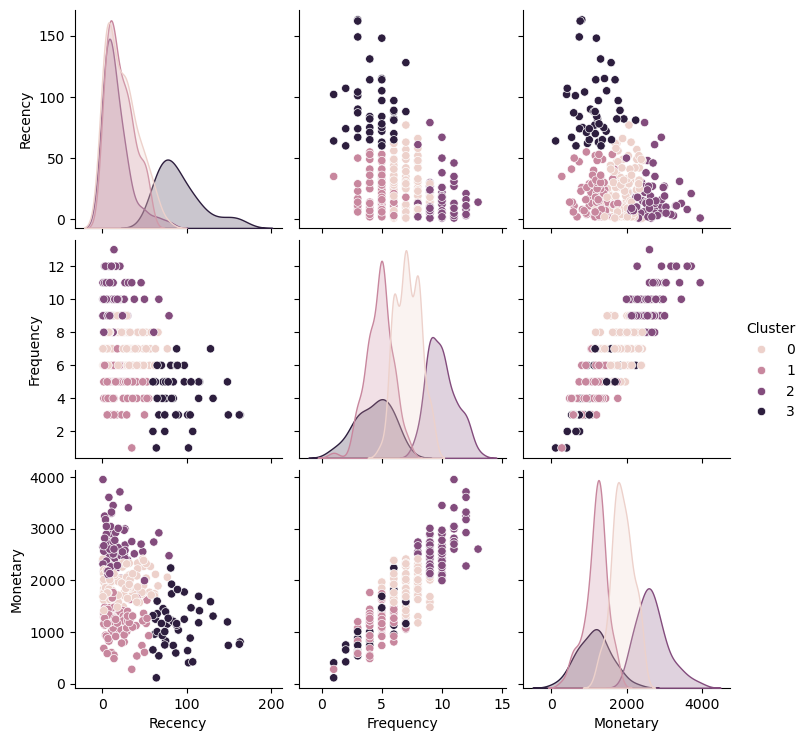

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(rfm, hue='Cluster', vars=['Recency', 'Frequency', 'Monetary'])
plt.show()


In [62]:
# Average RFM by Cluster
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Customer_ID': 'count'
}).rename(columns={'Customer_ID': 'CustomerCount'})

print(cluster_summary)

# Save to CSV
rfm.to_csv('Customer_Segments.csv', index=False)


           Recency  Frequency     Monetary  CustomerCount
Cluster                                                  
0        23.470588   7.166667  1882.839314            102
1        21.563218   4.781609  1181.078851             87
2        17.106061   9.969697  2680.614242             66
3        91.355556   4.333333  1135.224444             45


C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows wi

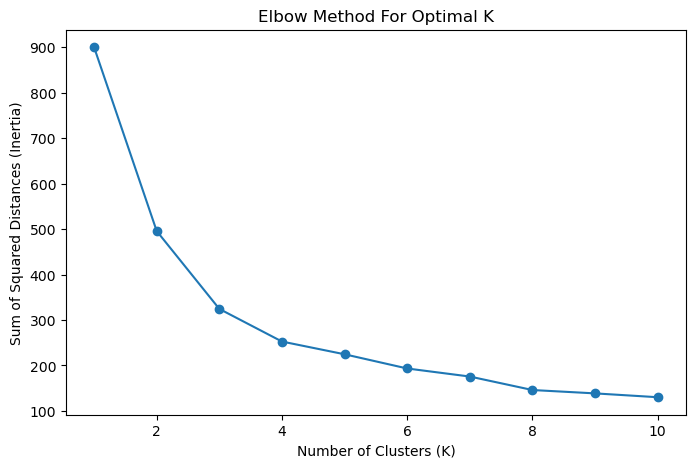

In [47]:
import os
os.environ["OMP_NUM_THREADS"] = "2"

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_df)
    sse[k] = kmeans.inertia_

plt.figure(figsize=(8, 5))
plt.plot(list(sse.keys()), list(sse.values()), marker='o')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Sum of Squared Distances (Inertia)")
plt.title("Elbow Method For Optimal K")
plt.show()


In [51]:
import os
os.environ["OMP_NUM_THREADS"] = "2"

from sklearn.metrics import silhouette_score

# Fit KMeans with chosen K (e.g., 4)
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(rfm_df)
cluster_labels = kmeans.labels_

# Calculate Silhouette Score
sil_score = silhouette_score(rfm_df, cluster_labels)
print(f'Silhouette Score for K=4: {sil_score:.3f}')

#Silhouette Score Interpretation: Above 0.5 → Good clustering. 0.3 - 0.5 → Acceptable. Below 0.3 → Poor clustering.

Silhouette Score for K=4: 0.328


C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [54]:
# Assuming the KMeans model with optimal k
optimal_k = 4  # or whatever K after Elbow Method
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(rfm_df)

# Add the cluster labels to the DataFrame
rfm_df['Cluster'] = kmeans.labels_


C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


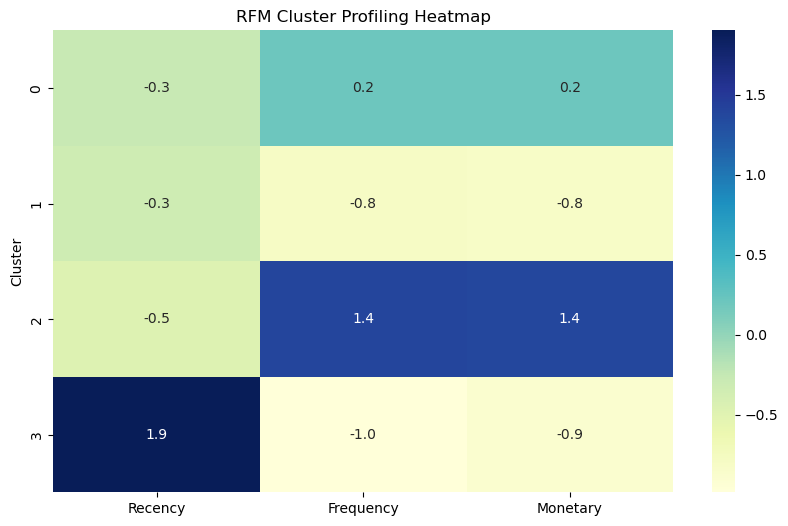

In [55]:
import seaborn as sns
rfm_profile = rfm_df.groupby('Cluster').mean()

plt.figure(figsize=(10,6))
sns.heatmap(rfm_profile, annot=True, cmap="YlGnBu", fmt=".1f")
plt.title('RFM Cluster Profiling Heatmap')
plt.show()


In [69]:
segment_map = {
    0: 'Loyal Customers',
    1: 'At Risk',
    2: 'Potential Loyalists',
    3: 'New Customers'
}

rfm_df['Segment'] = rfm_df['Cluster'].map(segment_map)



In [71]:
segment_summary = rfm_df.groupby('Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
})

# Add Customer Count manually
segment_summary['Customer_Count'] = rfm_df.groupby('Segment').size()

print(segment_summary)



                      Recency  Frequency  Monetary  Customer_Count
Segment                                                           
At Risk             -0.323170  -0.794535 -0.822582              87
Loyal Customers     -0.262361   0.210746  0.205261             102
New Customers        1.901875  -0.983480 -0.889743              45
Potential Loyalists -0.465269   1.392199  1.373734              66


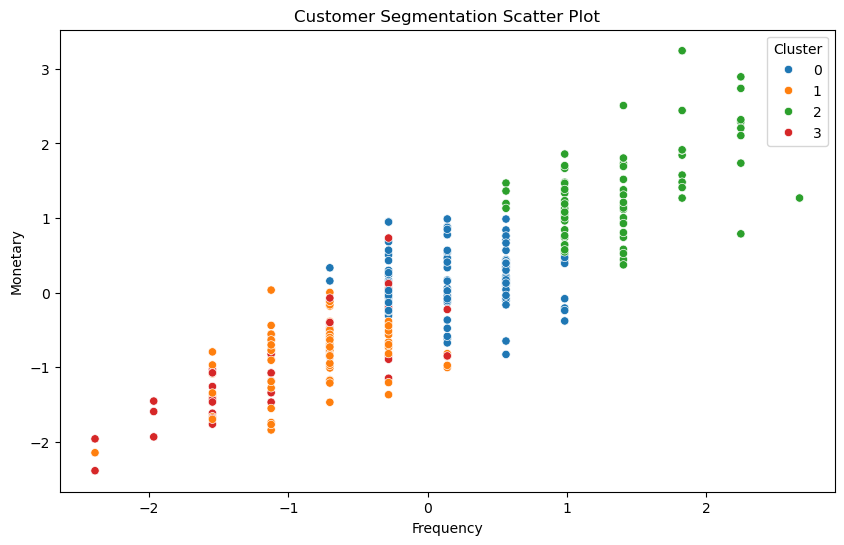

In [76]:
# Frequency vs Monetary colored by Cluster
plt.figure(figsize=(10,6))
sns.scatterplot(data=rfm_df, x='Frequency', y='Monetary', hue='Cluster', palette='tab10')
plt.title('Customer Segmentation Scatter Plot')
plt.show()


In [72]:
rfm_df.to_csv('Customer_Segments_Output.csv', index=False)